In [1]:
import torch.nn as nn
import torch
import torchvision.models as models
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import os

# summary

    https://www.cnblogs.com/skyfsm/p/6806246.html 基于深度学习的目标检测技术演进：R-CNN、Fast R-CNN、Faster R-CNN
    
    https://blog.csdn.net/u013293750/article/details/64904681 CNN+LSTM深度学习文字检测
    
    https://blog.csdn.net/forest_world/article/details/78566737 主流ocr算法：CNN+BLSTM+CTC架构
    
    https://blog.csdn.net/slade_ruan/article/details/78301842?utm_source=blogxgwz1 场景文本检测，CTPN tensorflow版本
    
    https://blog.csdn.net/Quincuntial/article/details/79475339?utm_source=blogxgwz1 CTPN论文翻译——中英文对照
    
    http://lib.csdn.net/article/deeplearning/61632  通过代码理解faster-RCNN中的RPN
    
    https://slade-ruan.me/2017/10/22/text-detection-ctpn/  论文阅读与实现--CTPN

    https://www.cnblogs.com/freeweb/p/6548208.html

    https://deepsense.ai/region-of-interest-pooling-in-tensorflow-example/

    https://www.cnblogs.com/king-lps/p/9031568.html

# data ready

In [2]:
from lib.datasets.factory import get_imdb
from lib.datasets.pascal_voc import pascal_voc
from lib.roi_data_layer.roidb import prepare_roidb
from lib.roi_data_layer.layer import RoIDataLayer


imdb = pascal_voc('trainval', '2007')
# roidb ROI框的坐标位置信息, 信息来源于Annotations目录下对图片的XML定义
prepare_roidb(imdb)   #  为方便训练，在原roidb信息基础上增加象image等等信息
roidb = imdb.roidb 
data_layer = RoIDataLayer(roidb, imdb.num_classes)

voc_2007_train
voc_2007_val
voc_2007_trainval
voc_2007_test
<bound method imdb.default_roidb of <lib.datasets.pascal_voc.pascal_voc object at 0x000001D2096BCE80>>
voc_2007_trainval gt roidb loaded from D:\PROJECT_TW\git\data\voc_2007_trainval_gt_roidb.pkl


# model

In [3]:
RPN_CHANNELS = 512
TRUNCATED = False
class Network(nn.Module):
    def __init__(self):
        nn.Module.__init__(self)
        self._predictions = {}
        self._losses = {}
        self._anchor_targets = {}
        self._proposal_targets = {}
        self._layers = {}
        self._gt_image = None
        self._act_summaries = {}
        self._score_summaries = {}
        self._event_summaries = {}
        self._image_gt_summaries = {}
        self._variables_to_fix = {}

    def create_architecture(self, num_classes, tag=None,anchor_scales=(16,), anchor_ratios=(0.5, 1, 2)):
        self._tag = tag
        self._num_classes = num_classes
        self._anchor_scales = anchor_scales
        self._num_scales = len(anchor_scales)
        self._anchor_ratios = anchor_ratios
        self._num_ratios = len(anchor_ratios)
        self._num_anchors = 10
        assert tag != None
        # Initialize layers
        self._init_modules()
        
    def _init_modules(self):
        self._init_head_tail()
        # rpn
        self.rpn_net = nn.Conv2d(self._net_conv_channels, RPN_CHANNELS, [3, 3], padding=1)
        self.rpn_bi_net = nn.LSTM(RPN_CHANNELS, 256, batch_first=True, bidirectional=True)
        self.rpn_cls_score_net = nn.LSTM(RPN_CHANNELS, self._num_anchors * 2, batch_first=True, bidirectional=False)
        self.rpn_bbox_pred_net = nn.LSTM(RPN_CHANNELS, self._num_anchors * 4, batch_first=True, bidirectional=False)
        self.init_weights()    
        
    # 对构建的网络参数（weight, bias）进行正则、初始化
    def init_weights(self):
        def normal_init(m, mean, stddev, truncated=False):
            """
                weight initalizer: truncated normal and random normal.
            """
            # x is a parameter
            if isinstance(m, nn.LSTM):
                init.xavier_normal_(m.all_weights[0][0])
                init.xavier_normal_(m.all_weights[0][1])
                if len(m.all_weights) == 2:   # 双向  LSTM
                    init.xavier_normal_(m.all_weights[1][0])
                    init.xavier_normal_(m.all_weights[1][1])
            else:
                if truncated:
                    m.weight.data.normal_().fmod_(2).mul_(stddev).add_(mean)  # not a perfect approximation
                else:
                    m.weight.data.normal_(mean, stddev)
                m.bias.data.zero_()
        normal_init(self.rpn_net, 0, 0.01, TRUNCATED)
        normal_init(self.rpn_cls_score_net,0, 0.01, TRUNCATED)
        normal_init(self.rpn_bbox_pred_net,0, 0.01, TRUNCATED)
        normal_init(self.rpn_bi_net,0, 0.01, TRUNCATED)
        

In [4]:
class vgg16(Network):
    def __init__(self):
        Network.__init__(self)
        self._feat_stride = [16, ]
        self._feat_compress = [1. / float(self._feat_stride[0]), ]
        self._net_conv_channels = 512
        self._fc7_channels = 4096

    def _init_head_tail(self):
        # 注意， 通过 models.vgg16() 加载的模型是基础模型，是还没有经过训练的模型， 所以需要load_pretrained_cnn从外部载入已训练好的权重信息
        # 而通过 models.vgg16(pretrained=True)，则是已训练好的模型，无需再加载模型，本次实现采用models.vgg16(pretrained=True)，无需再加载了
        # 注意预加载的是识别图像的（对于识字的需做更改）
        self.vgg = models.vgg16_bn(pretrained=True)
        # Remove fc8
        self.vgg.classifier = nn.Sequential(*list(self.vgg.classifier._modules.values())[:-1])

        # Fix the layers before conv3:
        for layer in range(12):
            for p in self.vgg.features[layer].parameters(): 
                p.requires_grad = False

        # not using the last maxpool layer
        self._layers['head'] = nn.Sequential(*list(self.vgg.features._modules.values())[:-1])
#         print(self._layers['head'])


    # 通过卷积网络VG16的feature层，抽取图片的特征
    def _image_to_head(self):
        net_conv = self._layers['head'](self._image)
        self._act_summaries['conv'] = net_conv
        return net_conv

    def _head_to_tail(self, pool5):
        pool5_flat = pool5.view(pool5.size(0), -1)
        fc7 = self.vgg.classifier(pool5_flat)
        return fc7


    # 注意， 通过 models.vgg16() 加载的模型是基础模型，是还没有经过训练的模型， 所以需要该方法从外部载入权重信息
    # 而通过 models.vgg16(pretrained=True)，则是已训练好的模型，无需再加载模型，本次实现采用models.vgg16(pretrained=True)，
    # 无需再加载了
    def load_pretrained_cnn(self, state_dict):
        self.vgg.load_state_dict({k:v for k,v in state_dict.items() if k in self.vgg.state_dict()})


# train

In [5]:
# https://blog.csdn.net/garfielder007/article/details/51378296  Python numpy函数hstack() vstack() stack() dstack() vsplit() concatenate()
from lib.layutils.generate_anchors import generate_anchors
import lib.layutils.anchor_target_layer as atl
import numpy as np

def generate_anchors_pre(height, width, feat_stride, anchor_scales=(8,16,32), anchor_ratios=(0.5,1,2)):
  """ A wrapper function to generate anchors given different scales
    Also return the number of anchors in variable 'length'
  """
  anchors = generate_anchors(ratios=np.array(anchor_ratios), scales=np.array(anchor_scales))
  A = anchors.shape[0]
  shift_x = np.arange(0, width) * feat_stride
  shift_y = np.arange(0, height) * feat_stride
  shift_x, shift_y = np.meshgrid(shift_x, shift_y)
  shifts = np.vstack((shift_x.ravel(), shift_y.ravel(), shift_x.ravel(), shift_y.ravel())).transpose()
  K = shifts.shape[0]
  # width changes faster, so here it is H, W, C
  anchors = anchors.reshape((1, A, 4)) + shifts.reshape((1, K, 4)).transpose((1, 0, 2))
  anchors = anchors.reshape((K * A, 4)).astype(np.float32, copy=False)
  length = np.int32(anchors.shape[0])

  return anchors, length

def _anchor_target_layer(rpn_cls_score, gt_boxes, im_info, feat_stride, anchors, num_anchors):
#     print('_anchor_target_layer begin .... 开始 。。。。')
    rpn_labels, rpn_bbox_targets, rpn_bbox_inside_weights, rpn_bbox_outside_weights = atl.anchor_target_layer(
        rpn_cls_score.data,
        gt_boxes.data.numpy(),
        im_info,
        feat_stride,
        anchors.data.numpy(),
        num_anchors)

    rpn_labels = torch.from_numpy(rpn_labels).float() #.set_shape([1, 1, None, None])
    rpn_bbox_targets = torch.from_numpy(rpn_bbox_targets).float() #.set_shape([1, None, None, self._num_anchors * 4])
    rpn_bbox_inside_weights = torch.from_numpy(rpn_bbox_inside_weights).float() #.set_shape([1, None, None, self._num_anchors * 4])
    rpn_bbox_outside_weights = torch.from_numpy(rpn_bbox_outside_weights).float() #.set_shape([1, None, None, self._num_anchors * 4])
    rpn_labels = rpn_labels.long()
#     self._anchor_targets['rpn_labels'] = rpn_labels
#     self._anchor_targets['rpn_bbox_targets'] = rpn_bbox_targets
#     self._anchor_targets['rpn_bbox_inside_weights'] = rpn_bbox_inside_weights
#     self._anchor_targets['rpn_bbox_outside_weights'] = rpn_bbox_outside_weights
#     for k in self._anchor_targets.keys():
#         self._score_summaries[k] = self._anchor_targets[k]
    

    return rpn_labels,rpn_bbox_targets,rpn_bbox_inside_weights,rpn_bbox_outside_weights


def _smooth_l1_loss(bbox_pred, bbox_targets, bbox_inside_weights, bbox_outside_weights, sigma=1.0, dim=[1]):
    sigma_2 = sigma ** 2
    box_diff = bbox_pred - bbox_targets
    in_box_diff = bbox_inside_weights * box_diff
    abs_in_box_diff = torch.abs(in_box_diff)
    smoothL1_sign = (abs_in_box_diff < 1. / sigma_2).detach().float()
    in_loss_box = torch.pow(in_box_diff, 2) * (sigma_2 / 2.) * smoothL1_sign \
                  + (abs_in_box_diff - (0.5 / sigma_2)) * (1. - smoothL1_sign)
    out_loss_box = bbox_outside_weights * in_loss_box
    loss_box = out_loss_box
    for i in sorted(dim, reverse=True):
        loss_box = loss_box.sum(i)
    loss_box = loss_box.mean()
    return loss_box

def _add_loss(rpn_cls_score_reshape,rpn_labels,
              rpn_bbox_pred,
              rpn_bbox_targets,
              rpn_bbox_inside_weights,
              rpn_bbox_outside_weights,
             sigma_rpn = 3.0):
    rpn_cls_score = rpn_cls_score_reshape.view(-1,2)
    rpn_label = rpn_labels.view(-1)
    rpn_select = (rpn_label.data != -1).nonzero().view(-1)
    rpn_cls_score = rpn_cls_score.index_select(0, rpn_select).contiguous().view(-1, 2)
    rpn_label = rpn_label.index_select(0, rpn_select).contiguous().view(-1)
    rpn_cross_entropy = F.cross_entropy(rpn_cls_score, rpn_label)
    
    rpn_loss_box = _smooth_l1_loss(rpn_bbox_pred, rpn_bbox_targets, rpn_bbox_inside_weights,
                                          rpn_bbox_outside_weights, sigma=sigma_rpn, dim=[1, 2, 3])
    
    loss = rpn_cross_entropy + rpn_loss_box
    return loss


In [7]:
# feat_stride：[16]VGG中conv5_3相比于输入图像缩小了16倍，也就是相邻两个点之间的stride=16 
feat_stride = [16, ]
ANCHOR_SCALES = [16]
ANCHOR_RATIOS = [0.5,1,2]
MOMENTUM = 0.9
lr = 0.001
DOUBLE_BIAS = True
BIAS_DECAY = False
WEIGHT_DECAY = 0.0005
EPCHO = 10000
num_anchors = 10

net = vgg16()
# print(imdb.num_classes)

net.create_architecture(imdb.num_classes, tag='default',
                                            anchor_scales=ANCHOR_SCALES,
                                            anchor_ratios=ANCHOR_RATIOS)
params = []

for key, value in dict(net.named_parameters()).items():
    if value.requires_grad:
        if 'bias' in key:
              params += [{'params':[value],'lr':lr*(DOUBLE_BIAS + 1), 
                  'weight_decay': BIAS_DECAY and WEIGHT_DECAY or 0}]
        else:
              params += [{'params':[value],'lr':lr, 
                  'weight_decay': WEIGHT_DECAY}]
                
if os.path.exists('D:\\PROJECT_TW\\git\\data\\example\\model\\text_detect.pkl'):
    net.load_state_dict(torch.load('D:\\PROJECT_TW\\git\\data\\example\\model\\text_detect.pkl'))
                

optimizer = torch.optim.SGD(params,lr=lr, momentum=MOMENTUM)

for step in range(EPCHO):
    blobs = data_layer.forward()
    image = torch.from_numpy(blobs['data'].transpose([0,3,1,2]))
    im_info = blobs['im_info']
    gt_boxes = torch.from_numpy(blobs['gt_boxes'])
#     print(image.size())
    net_conv = net._layers['head'](image)
#     print('net conv size --> {}'.format(net_conv.size()))
    
    # height, width   build the anchors for the image
#     print('net conv size {}'.format(net_conv.size()))
    anchors, length = generate_anchors_pre(net_conv.size(2), net_conv.size(3),feat_stride=feat_stride,anchor_scales=(16,))
    anchors = torch.from_numpy(anchors)
#     print('anchors shape {}'.format(anchors.shape))
    rpn = F.relu(net.rpn_net(net_conv))  # ( N , C, H, W）
    
    # ( N , C, H, W）  --》 （N * H, W, C)
    rpn_reshape = rpn.permute(0,2,3,1).squeeze(0)
    
    # 双向LSTM网络   -->  (N*H, W, C)
    rpn_blstm,_ = net.rpn_bi_net(rpn_reshape)
    rpn_blstm = F.relu(rpn_blstm)  # 注意另外可以考虑采用batch normal方法对数据进行整理
    
    # test detect 采用随机生成 偏移变量数组和得分初始化数组  
    # 与rpn_blsm[N*H*W,C]矩阵相乘方式得到其偏移和分类得分 [N,H,W,4*num anchor或2]
    # 这里暂时用lstm 来代替，后面需改成上述方案实现
    rpn_cls_score,_ = net.rpn_cls_score_net(rpn_blstm)   # [W H, num_anchors*2], num_anchors = 10
#     print('rpn cls score size {}'.format(rpn_cls_score.size()))

    
    rpn_cls_score = rpn_cls_score.permute(2,0,1).unsqueeze(0)
    rpn_cls_score_reshape = rpn_cls_score.contiguous().view(1,2,-1,rpn_cls_score.size()[3])  # N , 2*10, H, W   --->  N, 2, 10*H , W
    rpn_cls_score = rpn_cls_score.permute(0,2,3,1)
       
    # 得到坐标点的10个分类概率（二分类方法)
    rpn_cls_prob_reshape = F.softmax(rpn_cls_score_reshape,dim=1)           # N 2 H*NUM_ANCHORS W
    rpn_cls_prob = rpn_cls_prob_reshape.view(1,2*10,-1,rpn_cls_prob_reshape.shape[-1])  # N,2,num_anch*h, w --> N, 2*num_anchor h w
    rpn_cls_prob = rpn_cls_prob.permute(0,2,3,1)
    
    rpn_cls_pred = rpn_cls_score_reshape.permute(0,2,3,1).contiguous()   # N H*NUM_ANCHORS W 2
    rpn_cls_pred = torch.max(rpn_cls_pred.view(-1,2),1)[1]
    
    rpn_bbox_pred,_ = net.rpn_bbox_pred_net(rpn_blstm)   # [W H, num_anchors*4], num_anchors = 10
    rpn_bbox_pred = rpn_bbox_pred.unsqueeze(0)

    rpn_labels,rpn_bbox_targets,rpn_bbox_inside_weights,rpn_bbox_outside_weights = _anchor_target_layer(rpn_cls_score,
                                                                                                        gt_boxes,
                                                                                                        im_info,
                                                                                                        feat_stride,
                                                                                                        anchors,
                                                                                                        num_anchors)
    
    loss = _add_loss(rpn_cls_score_reshape,rpn_labels,rpn_bbox_pred,
                     rpn_bbox_targets,rpn_bbox_inside_weights,rpn_bbox_outside_weights)
    
    print('{} loss --> {}'.format(step,loss))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if step % 10 == 0:
        print('save model ')
        torch.save(net.state_dict(), 'D:\\PROJECT_TW\\git\\data\\example\\model\\text_detect.pkl')
    
    

train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
0 loss --> 2.009660482406616
save model 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
1 loss --> 2.187434196472168
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
2 loss --> 0.8454964756965637
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
3 loss --> 4.096347808837891
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
4 loss --> 1.635135293006897
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
5 loss --> 4.967892646789551
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
6 loss --> 1.036629319190979
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
7 loss --> 2.1792221069335938
train image name : num 0 : D:\PROJECT_TW\g

67 loss --> 2.6502647399902344
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
68 loss --> 3.9654700756073
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
69 loss --> 2.41717267036438
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
70 loss --> 3.2843780517578125
save model 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
71 loss --> 2.8316617012023926
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
72 loss --> 2.461043357849121
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
73 loss --> 3.2835042476654053
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
74 loss --> 2.4040133953094482
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
75 loss --> 2.89011812210083
train

train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
135 loss --> 2.0026156902313232
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
136 loss --> 1.5209041833877563
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
137 loss --> 1.089452862739563
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
138 loss --> 2.5648036003112793
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
139 loss --> 1.9238884449005127
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
140 loss --> 3.2006311416625977
save model 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
141 loss --> 2.7609620094299316
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
142 loss --> 2.583038806915283
train image name : num

train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
202 loss --> 1.4725470542907715
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
203 loss --> 2.110405445098877
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
204 loss --> 3.492196559906006
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
205 loss --> 3.132211208343506
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
206 loss --> 1.772560954093933
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
207 loss --> 0.7180238962173462
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
208 loss --> 1.714748740196228
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
209 loss --> 2.1170685291290283
train image name : num 0 : D:\PROJECT

train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
269 loss --> 3.278425455093384
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
270 loss --> 1.0959298610687256
save model 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
271 loss --> 1.5354385375976562
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
272 loss --> 2.5860884189605713
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
273 loss --> 2.563971519470215
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
274 loss --> 1.5004650354385376
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
275 loss --> 2.093111753463745
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
276 loss --> 3.728672742843628
train image name : num 0

train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
336 loss --> 4.7915754318237305
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
337 loss --> 2.146955966949463
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
338 loss --> 1.8878854513168335
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
339 loss --> 1.7633204460144043
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
340 loss --> 2.636259078979492
save model 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
341 loss --> 2.2545716762542725
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
342 loss --> 2.142508029937744
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
343 loss --> 2.934673547744751
train image name : num 0

train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
403 loss --> 1.2534632682800293
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
404 loss --> 3.927180051803589
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
405 loss --> 1.9142076969146729
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
406 loss --> 3.1420764923095703
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
407 loss --> 1.079879879951477
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
408 loss --> 2.8211944103240967
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
409 loss --> 1.1295372247695923
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
410 loss --> 1.9087507724761963
save model 
train image name : num

train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
470 loss --> 0.77040034532547
save model 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
471 loss --> 0.8862285614013672
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
472 loss --> 3.1158316135406494
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
473 loss --> 0.7177409529685974
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
474 loss --> 2.378702163696289
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
475 loss --> 0.947171151638031
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
476 loss --> 1.256906270980835
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
477 loss --> 2.8210678100585938
train image name : num 0 

train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
537 loss --> 3.0568535327911377
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
538 loss --> 1.4365177154541016
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
539 loss --> 1.767188310623169
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
540 loss --> 1.6090102195739746
save model 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
541 loss --> 1.066169261932373
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
542 loss --> 2.3849313259124756
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
543 loss --> 0.7378987073898315
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
544 loss --> 0.780516505241394
train image name : num 

train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
604 loss --> 0.7397515773773193
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
605 loss --> 5.221047401428223
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
606 loss --> 2.09843111038208
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
607 loss --> 2.2391068935394287
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
608 loss --> 3.1471385955810547
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
609 loss --> 3.6711373329162598
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
610 loss --> 3.0547094345092773
save model 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
611 loss --> 0.7425016760826111
train image name : num 

train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
671 loss --> 0.7324737906455994
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
672 loss --> 2.0189690589904785
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
673 loss --> 2.2550671100616455
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
674 loss --> 0.8764199614524841
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
675 loss --> 1.5598900318145752
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
676 loss --> 1.2526652812957764
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
677 loss --> 2.3228933811187744
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
678 loss --> 5.144105911254883
train image name : num 0 : D:\PRO

train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
738 loss --> 3.9273452758789062
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
739 loss --> 1.7739365100860596
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
740 loss --> 2.1608495712280273
save model 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
741 loss --> 2.375413417816162
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
742 loss --> 4.067695617675781
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
743 loss --> 2.395557403564453
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
744 loss --> 2.760503053665161
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
745 loss --> 2.3959157466888428
train image name : num 0

train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
805 loss --> 3.1308722496032715
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
806 loss --> 0.880437970161438
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
807 loss --> 1.4996421337127686
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
808 loss --> 1.7338249683380127
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
809 loss --> 0.8350374102592468
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
810 loss --> 1.70278000831604
save model 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
811 loss --> 4.233005046844482
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
812 loss --> 2.908238649368286
train image name : num 0 

train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
872 loss --> 2.7022957801818848
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
873 loss --> 1.3959002494812012
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
874 loss --> 4.0738935470581055
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
875 loss --> 3.123823881149292
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
876 loss --> 0.7772049307823181
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
877 loss --> 1.9285215139389038
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
878 loss --> 2.3447837829589844
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
879 loss --> 3.203484535217285
train image name : num 0 : D:\PROJ

train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
939 loss --> 2.7858083248138428
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
940 loss --> 2.8575823307037354
save model 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
941 loss --> 0.8803107142448425
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
942 loss --> 1.0896483659744263
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
943 loss --> 1.3452813625335693
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
944 loss --> 1.050131916999817
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
945 loss --> 2.2388105392456055
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
946 loss --> 2.781322717666626
train image name : num

train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
1006 loss --> 5.015654563903809
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
1007 loss --> 1.4727267026901245
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
1008 loss --> 1.9361495971679688
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
1009 loss --> 1.3107411861419678
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
1010 loss --> 2.2990574836730957
save model 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
1011 loss --> 1.2057052850723267
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
1012 loss --> 3.945683717727661
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
1013 loss --> 3.3822457790374756
train image na

train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
1072 loss --> 1.1417169570922852
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
1073 loss --> 3.4938106536865234
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
1074 loss --> 3.82794189453125
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
1075 loss --> 1.7344162464141846
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
1076 loss --> 1.3220723867416382
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
1077 loss --> 3.4069464206695557
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
1078 loss --> 4.154877662658691
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
1079 loss --> 1.8502877950668335
train image name : num 0 : 

1138 loss --> 0.7325968742370605
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
1139 loss --> 2.134265422821045
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
1140 loss --> 1.755779504776001
save model 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
1141 loss --> 1.8486518859863281
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
1142 loss --> 3.396393060684204
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
1143 loss --> 2.7757415771484375
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
1144 loss --> 2.8254809379577637
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
1145 loss --> 0.7254807949066162
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
1146 loss --> 2

train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
1205 loss --> 4.022655487060547
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
1206 loss --> 1.7034831047058105
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
1207 loss --> 3.0931077003479004
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
1208 loss --> 3.1214330196380615
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
1209 loss --> 3.3604795932769775
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
1210 loss --> 3.2124276161193848
save model 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
1211 loss --> 1.6233575344085693
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
1212 loss --> 1.2109286785125732
train image n

train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
1271 loss --> 1.206460952758789
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
1272 loss --> 3.0285143852233887
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
1273 loss --> 3.1878609657287598
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
1274 loss --> 3.095500946044922
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
1275 loss --> 2.4888787269592285
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
1276 loss --> 5.092476844787598
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
1277 loss --> 2.4280521869659424
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
1278 loss --> 3.1392741203308105
train image name : num 0 : 

1337 loss --> 1.797021746635437
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
1338 loss --> 2.3723807334899902
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
1339 loss --> 2.4146828651428223
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
1340 loss --> 1.8683128356933594
save model 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
1341 loss --> 3.8203585147857666
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
1342 loss --> 3.153607130050659
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
1343 loss --> 1.5113070011138916
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
1344 loss --> 1.5336534976959229
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
1345 loss --> 

train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
1404 loss --> 3.1508374214172363
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
1405 loss --> 0.7005962133407593
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
1406 loss --> 2.059797763824463
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
1407 loss --> 2.82859468460083
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
1408 loss --> 1.8233212232589722
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
1409 loss --> 2.794179677963257
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
1410 loss --> 2.3990588188171387
save model 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
1411 loss --> 1.3795316219329834
train image name

KeyboardInterrupt: 

In [32]:
# 重新加载某模块
import lib.layutils.anchor_target_layer as atl
import importlib
importlib.reload(atl)

import lib.utils.bbox as bbox
importlib.reload(bbox)
# print(rpn_cls_score.shape[1:3])
rpn_labels = _anchor_target_layer(rpn_cls_score,
                                  gt_boxes,
                                  im_info,
                                  feat_stride,
                                  anchors,
                                  num_anchors
                                 )
print(rpn_labels.size())

_anchor_target_layer begin .... 开始 。。。。
torch.Size([1, 37, 54, 10])


In [7]:
torch.save(net.state_dict(), 'D:\\PROJECT_TW\\git\\data\\example\\model\\text_detect.pkl')

# valid

In [8]:
feat_stride = [16, ]
ANCHOR_SCALES = [16]
ANCHOR_RATIOS = [0.5,1,2]
num_anchors = 10
net = vgg16()
net.create_architecture(imdb.num_classes, tag='default',
                                            anchor_scales=ANCHOR_SCALES,
                                            anchor_ratios=ANCHOR_RATIOS)    
if os.path.exists('D:\\PROJECT_TW\\git\\data\\example\\model\\text_detect.pkl'):
    net.load_state_dict(torch.load('D:\\PROJECT_TW\\git\\data\\example\\model\\text_detect.pkl'))

In [9]:
import lib.text_connector.text_proposal_connector as tpc
import lib.utils.nms as nms
import lib.layutils.proposal_layer as psl
import matplotlib.pyplot as plt
import cv2
import numpy as np
import importlib
importlib.reload(tpc)
importlib.reload(psl)
import time

DEBUG = True

def connect_proposal(text_proposals, scores, im_size):
    cp = tpc.TextProposalConnector()
    line = cp.get_text_lines(text_proposals, scores, im_size)
    return line


def save_results(image_name, im, line, thresh):
    inds = np.where(line[:, -1] >= thresh)[0]
#     print('inds --->{}'.format(len(inds)))
    if len(inds) == 0:
        return
    
    for i in inds:
        bbox = line[i, :]
#         print('bbox {}--> \n {}'.format(i,bbox))
        score = line[i, -1]
        cv2.rectangle(
            im, (bbox[0], bbox[1]), (bbox[6], bbox[7]),
            color=(0, 255, 255),
            thickness=2)
    plt.imshow(im,'brg')
    plt.show()
    cv2.imwrite('d:\\1.jpg',im)
    
def testConnectProposal():
    plt.rcParams['figure.figsize'] = 15, 10
    img = cv2.imread(roidb[1]['image'])
    boxes = roidb[1]['boxes']
    scores = np.ones(boxes.shape[0])
    CONF_THRESH = 0.9
    NMS_THRESH = 0.3
    dets = np.hstack((boxes, scores[:, np.newaxis])).astype(np.float32)
    keep = nms.nms(dets, NMS_THRESH)
    dets = dets[keep,:]
    line = connect_proposal(dets[:, 0:4], dets[:, 4], img.shape)
    line = line.astype(int)
    save_results("newimg.jpg", img, line, thresh=0.7)

def validNet():
    feat_stride = [16, ]
    ANCHOR_SCALES = [16]
    ANCHOR_RATIOS = [0.5,1,2]
    num_anchors = 10

    blobs = data_layer.forward()
    
    image = blobs['data']
    image_src = image.copy()
    im_info = blobs['im_info']
    
    image = torch.from_numpy(blobs['data'].transpose([0,3,1,2]))
    net.eval()
    net_conv =  net_conv = net._layers['head'](image)
    anchors, length = generate_anchors_pre(net_conv.size(2), net_conv.size(3),feat_stride=feat_stride,anchor_scales=(16,))
    anchors = torch.from_numpy(anchors)
    rpn = F.relu(net.rpn_net(net_conv))
    rpn_reshape = rpn.permute(0,2,3,1).squeeze(0)
    rpn_blstm,_ = net.rpn_bi_net(rpn_reshape)
    rpn_blstm = F.relu(rpn_blstm) 
    rpn_cls_score,_ = net.rpn_cls_score_net(rpn_blstm)
    rpn_cls_score = rpn_cls_score.permute(2,0,1).unsqueeze(0)
    rpn_cls_score_reshape = rpn_cls_score.contiguous().view(1,2,-1,rpn_cls_score.size()[3]) 
    rpn_cls_score = rpn_cls_score.permute(0,2,3,1)
    rpn_cls_prob_reshape = F.softmax(rpn_cls_score_reshape,dim=1)  
    
    if DEBUG:
        print('rpn cls score size --> {}'.format(rpn_cls_score.size()))
        print('rpn cls prob reshape size --> {}'.format(rpn_cls_score_reshape.size()))
        
    rpn_cls_prob = rpn_cls_prob_reshape.view(1,2*10,-1,rpn_cls_prob_reshape.shape[-1])  # N,2,num_anch*h, w --> N, 2*num_anchor h w
    if DEBUG:
        print('rpn cls prob size -->{}'.format(rpn_cls_prob.size()))
    
    rpn_cls_prob = rpn_cls_prob.permute(0,2,3,1)
    
    if DEBUG:
        print('rpn cls prob size -->{}'.format(rpn_cls_prob.size()))    
        
    rpn_cls_pred = rpn_cls_score_reshape.permute(0,2,3,1).contiguous()
    if DEBUG:
        print('rpn cls pred size -->{}'.format(rpn_cls_pred.size()))    
    
    rpn_cls_pred = torch.max(rpn_cls_pred.view(-1,2),1)[1]
    rpn_bbox_pred,_ = net.rpn_bbox_pred_net(rpn_blstm) 
    rpn_bbox_pred = rpn_bbox_pred.unsqueeze(0)
    
    blob, scores = psl.proposal_layer(rpn_cls_prob, 
                                      rpn_bbox_pred.contiguous(),
                                      im_info,
                                      'TEST',
                                      feat_stride,
                                      anchors,
                                      num_anchors)
    return image_src, blob, scores

def showValidNet():
    start_time = time.time()
    with torch.no_grad():
        image_src, blob, scores = validNet()
    print('handle times {:.4f}'.format((time.time() - start_time)))  
    plt.rcParams['figure.figsize'] = 15, 10
    boxes = blob.data.numpy()[:,1:5]
    score = scores.data.numpy()
    score = score.reshape(score.shape[0])
    image_new = image_src.reshape(image_src.shape[1],image_src.shape[2], image_src.shape[3])

    dets = np.hstack((boxes, score[:, np.newaxis])).astype(np.float32)
    keep = nms.nms(dets, 0.3)
    dets = dets[keep,:]
    line = connect_proposal(dets[:, 0:4], dets[:, 4], image_new.shape)
    line = line.astype(int)
#     print(line)
    # image_new = image_src.reshape(image_src.shape[1],image_src.shape[2], image_src.shape[3])
    save_results('newimg.jpg',image_new, line, 0)    
    
showValidNet()


train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
rpn cls score size --> torch.Size([1, 37, 48, 20])
rpn cls prob reshape size --> torch.Size([1, 2, 370, 48])
rpn cls prob size -->torch.Size([1, 20, 37, 48])
rpn cls prob size -->torch.Size([1, 37, 48, 20])
rpn cls pred size -->torch.Size([1, 370, 48, 2])
handle times 18.3797


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 1500x1000 with 1 Axes>

[[144 232 768 232 144 599 768 599   0]
 [ 32 282 144 282  32 599 144 599   0]
 [368   0 528   0 368 214 528 214   0]
 [ 32   0 368   0  32 326 368 326   0]
 [336 123 416 123 336 448 416 448   0]
 [416 132 560 132 416 277 560 277   0]
 [528 105 560 105 528 218 560 218   0]
 [  0 298  32 298   0 417  32 417   0]
 [560  90 768  90 560 599 768 599   0]
 [608   6 768   6 608 370 768 370   0]
 [528   0 768   0 528 140 768 140   0]
 [  0 135  32 135   0 245  32 245   0]
 [  0 403  32 403   0 522  32 522   0]
 [208 178 240 178 208 272 240 272   0]
 [  0 236 240 236   0 411 240 411   0]
 [384  86 416  86 384 192 416 192   0]
 [  0   4 416   4   0  89 416  89   0]
 [  0  55  32  55   0 169  32 169   0]
 [  0 501  80 501   0 599  80 599   0]
 [432 231 464 231 432 357 464 357   0]
 [320 227 432 227 320 368 432 368   0]
 [240 252 432 252 240 357 432 357   0]
 [112   0 160   0 112  56 160  56   0]
 [ 80  86 128  86  80 194 128 194   0]
 [128 220 160 220 128 332 160 332   0]
 [304 530 752 530 304 599

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


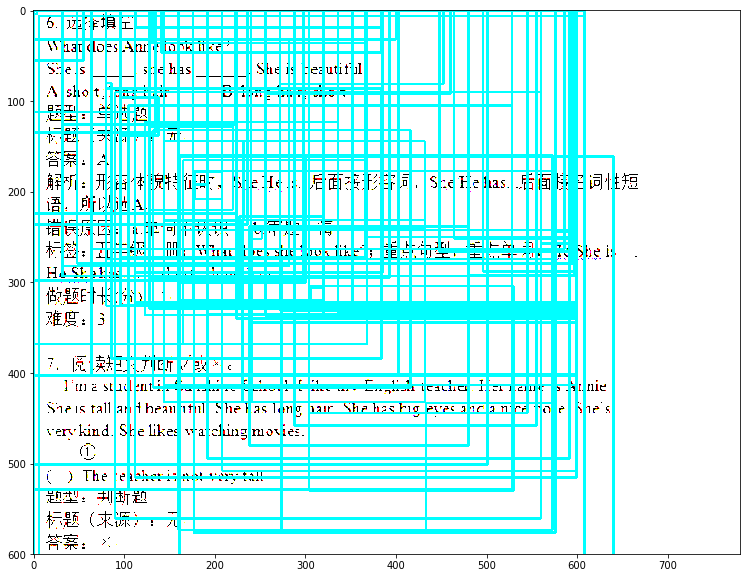

In [76]:
import numpy as np
